<a href="https://colab.research.google.com/github/fineliaapp/backtesting-tool/blob/main/colab_backtest_etf_sintetici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtest ETF sintetici (TER + leva giornaliera + FX) — Colab template

Questo notebook è un template “plug & play” per:
- download dati (Yahoo Finance per indici/ETF) + caching su Parquet
- FX da FRED (es. DEXUSEU) per overlay EUR
- costruzione NAV “ETF sintetico” con **TER**, **leva giornaliera**, **funding spread**
- backtest multipli + metriche base + grafici

> Nota: per uso didattico/personale. Per uso commerciale/redistribuzione dataset, verifica licenze delle fonti.


## 0) Setup cartelle

In [2]:
from pathlib import Path

BASE = Path("/content")
DATA = BASE / "data"
RAW = DATA / "raw"
PROC = DATA / "processed"
REPORTS = BASE / "reports"

for p in [RAW, PROC, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

RAW, PROC, REPORTS


(PosixPath('/content/data/raw'),
 PosixPath('/content/data/processed'),
 PosixPath('/content/reports'))

## 1) Install dipendenze

In [3]:
!pip -q install yfinance pyarrow pandas numpy matplotlib requests nbformat

## 2) Imports + Config

In [4]:
import math
from dataclasses import dataclass
from typing import Optional, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from io import StringIO

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)


In [14]:
@dataclass
class DataConfig:
    start: str = "2000-01-01"
    end: Optional[str] = None  # None -> oggi
    cache: bool = True
    tz: str = "UTC"

@dataclass
class SyntheticETFConfig:
    # leva e costi
    leverage: float = 1.0               # es: 2.0
    ter_annual: float = 0.0020          # 0.20% -> 0.0020
    funding_spread_annual: float = 0.00 # costo extra annuo (oltre TER), es 0.0225 = 2.25%
    # FX overlay
    base_ccy: str = "USD"               # valuta sottostante
    out_ccy: str = "EUR"                # valuta NAV sintetico
    fx_pair: str = "DEXUSEU"            # FRED: USD per 1 EUR (DEXUSEU)
    fx_unhedged: bool = True            # True: aggiunge FX return; False: ignora FX
    # label
    name: str = "synthetic"

DATA_CFG = DataConfig(start="2005-01-01", cache=True)


## 3) Cache I/O (Parquet)

In [6]:
def cache_path(kind: str, key: str) -> Path:
    safe = key.replace("/", "_").replace("^", "IDX_").replace("=", "_")
    return PROC / f"{kind}__{safe}.parquet"

def save_parquet(df: pd.DataFrame, path: Path) -> None:
    df.to_parquet(path, index=True)

def load_parquet(path: Path) -> pd.DataFrame:
    return pd.read_parquet(path)


## 4) Downloader: Yahoo Finance (indici / ETF)
Rispetta `multi_level_index=False`.

In [8]:
def fetch_yahoo(symbol: str, cfg: DataConfig) -> pd.DataFrame:
    """
    Ritorna DF indicizzato per data con colonne:
    close, adj_close (se presente), currency (best-effort), symbol
    """
    cp = cache_path("yahoo", symbol)
    if cfg.cache and cp.exists():
        df = load_parquet(cp)
        df.index = pd.to_datetime(df.index)
        return df

    df = yf.download(
        symbol,
        start=cfg.start,
        end=cfg.end,
        auto_adjust=False,
        progress=False,
        group_by="column",
        threads=True,
        multi_level_index=False,
    )

    if df is None or df.empty:
        raise ValueError(f"Nessun dato da Yahoo per {symbol}")

    out = pd.DataFrame(index=pd.to_datetime(df.index))
    out["close"] = df["Close"].astype(float)
    out["adj_close"] = df["Adj Close"].astype(float) if "Adj Close" in df.columns else np.nan
    out["symbol"] = symbol

    # currency: non sempre disponibile
    try:
        info = yf.Ticker(symbol).info
        out["currency"] = info.get("currency", None)
    except Exception:
        out["currency"] = None

    if cfg.cache:
        save_parquet(out, cp)

    return out


## 5) Downloader: FX da FRED (semplice)
Per molte serie (es. DEXUSEU) funziona anche senza API key.

In [9]:
def fetch_fred_series(series_id: str, cfg: DataConfig) -> pd.DataFrame:
    cp = cache_path("fred", series_id)
    if cfg.cache and cp.exists():
        df = load_parquet(cp)
        df.index = pd.to_datetime(df.index)
        return df

    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()

    df = pd.read_csv(StringIO(r.text))
    df.columns = ["date", "value"]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    df = df.loc[df.index >= pd.to_datetime(cfg.start)]
    if cfg.end:
        df = df.loc[df.index <= pd.to_datetime(cfg.end)]

    out = pd.DataFrame(index=df.index)
    out["value"] = df["value"].astype(float)
    out["series_id"] = series_id

    if cfg.cache:
        save_parquet(out, cp)

    return out


## 6) Normalizzazione: rendimenti + allineamento

In [10]:
def to_returns(price: pd.Series) -> pd.Series:
    return price.astype(float).pct_change()

def align_on_intersection(a: pd.Series, b: pd.Series) -> Tuple[pd.Series, pd.Series]:
    idx = a.dropna().index.intersection(b.dropna().index)
    return a.loc[idx], b.loc[idx]


## 7) Motore 'ETF sintetico'
- Leva giornaliera su rendimenti
- TER + funding (drag giornaliero)
- FX overlay unhedged (se base_ccy != out_ccy) usando DEXUSEU (USD per 1 EUR) -> USD→EUR = 1/DEXUSEU

In [11]:
def annual_to_daily_cost(annual_rate: float, trading_days: int = 252) -> float:
    return annual_rate / trading_days

def build_synthetic_nav(
    underlying_close: pd.Series,
    cfg: SyntheticETFConfig,
    fx_series: Optional[pd.Series] = None,
    start_nav: float = 100.0,
) -> pd.DataFrame:
    u = underlying_close.dropna().copy()
    u_ret = to_returns(u).dropna()

    daily_cost = annual_to_daily_cost(cfg.ter_annual + cfg.funding_spread_annual)

    # leva + costi (approccio semplice)
    ret = (cfg.leverage * u_ret) - daily_cost

    # FX overlay (unhedged)
    if cfg.fx_unhedged and (cfg.base_ccy != cfg.out_ccy):
        if fx_series is None:
            raise ValueError("fx_series richiesto per fx_unhedged=True e valute diverse.")

        fx = fx_series.dropna().copy()

        # default: DEXUSEU = USD per 1 EUR -> USD->EUR = 1/DEXUSEU
        if cfg.fx_pair == "DEXUSEU":
            fx_usd_eur = 1.0 / fx
            fx_ret = to_returns(fx_usd_eur).dropna()
        else:
            fx_ret = to_returns(fx).dropna()

        ret, fx_ret = align_on_intersection(ret, fx_ret)

        # fattore totale in EUR: (1+r_asset_usd)*(1+r_usd_eur)-1
        ret = (1.0 + ret) * (1.0 + fx_ret) - 1.0

    nav = (1.0 + ret).cumprod() * float(start_nav)

    out = pd.DataFrame(index=nav.index)
    out["nav"] = nav
    out["ret"] = ret
    return out


## 8) Metriche base

In [12]:
def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def cagr(nav: pd.Series, periods_per_year: int = 252) -> float:
    nav = nav.dropna()
    if len(nav) < 2:
        return float("nan")
    years = len(nav) / periods_per_year
    return float((nav.iloc[-1] / nav.iloc[0]) ** (1 / years) - 1)

def sharpe(returns: pd.Series, rf_annual: float = 0.0, periods_per_year: int = 252) -> float:
    r = returns.dropna()
    if r.empty:
        return float("nan")
    rf_daily = rf_annual / periods_per_year
    excess = r - rf_daily
    vol = excess.std()
    if vol == 0 or np.isnan(vol):
        return float("nan")
    return float((excess.mean() / vol) * math.sqrt(periods_per_year))

def summary_stats(df_nav: pd.DataFrame) -> Dict[str, float]:
    nav = df_nav["nav"]
    ret = df_nav["ret"]
    return {
        "CAGR": cagr(nav),
        "MaxDD": max_drawdown(nav),
        "Sharpe(0%)": sharpe(ret, rf_annual=0.0),
        "FinalNAV": float(nav.iloc[-1]),
    }


## 9) Esempio: S&P 500 (USD) → NAV sintetico in EUR (unhedged)

In [16]:
spx = fetch_yahoo("^GSPC", DATA_CFG)
fx = fetch_fred_series("DEXUSEU", DATA_CFG)

spx_close = spx["adj_close"].fillna(spx["close"])
fx_series = fx["value"]

cfg = SyntheticETFConfig(
    leverage=3.0,
    ter_annual=0.0060,               # 0.60%
    funding_spread_annual=0.0225,    # 2.25% (esempio)
    base_ccy="USD",
    out_ccy="EUR",
    fx_pair="DEXUSEU",
    fx_unhedged=True,
    name="SPX_2x_synth_EUR"
)

bt = build_synthetic_nav(spx_close, cfg, fx_series=fx_series, start_nav=100.0)
stats = summary_stats(bt)
stats


{'CAGR': 0.10593997662366772,
 'MaxDD': -0.963696541490815,
 'Sharpe(0%)': 0.46365651584730455,
 'FinalNAV': 793.1117474881087}

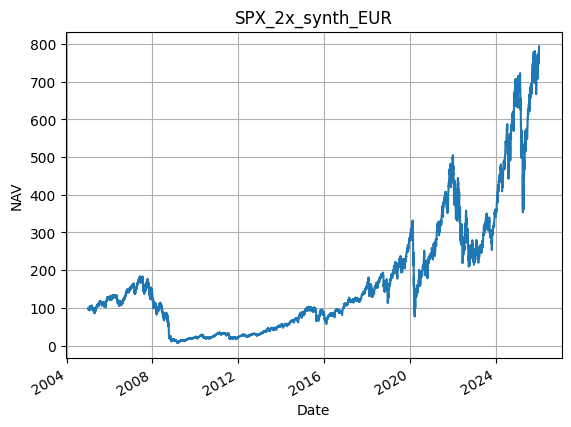

In [17]:
plt.figure()
bt["nav"].plot()
plt.title(cfg.name)
plt.xlabel("Date")
plt.ylabel("NAV")
plt.grid(True)
plt.show()


## 10) Backtest multipli (registry)

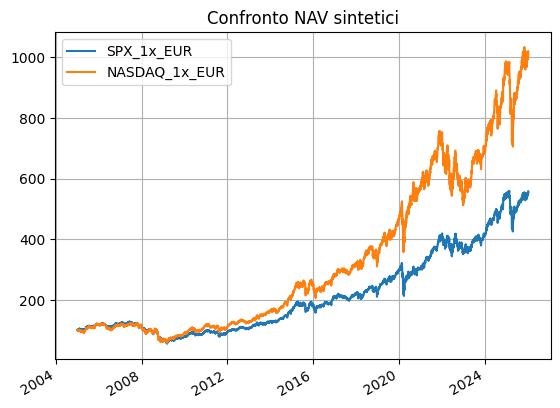

,CAGR,MaxDD,Sharpe(0%),FinalNAV
SPX_1x_EUR,0.086148,-0.568547,0.517533,558.146825
NASDAQ_1x_EUR,0.118623,-0.531039,0.613093,1020.383807


from matplotlib import pyplot as plt
_df_0['CAGR'].plot(kind='hist', bins=20, title='CAGR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MaxDD'].plot(kind='hist', bins=20, title='MaxDD')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Sharpe(0%)'].plot(kind='hist', bins=20, title='Sharpe(0%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['FinalNAV'].plot(kind='hist', bins=20, title='FinalNAV')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='CAGR', y='MaxDD', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='MaxDD', y='Sharpe(0%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Sharpe(0%)', y='FinalNAV', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['CAGR']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'CAGR'}, axis=1)
              .sort_values('CAGR', ascending=True))
  xs = counted['CAGR']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('CAGR', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('CAGR')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MaxDD']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MaxDD'}, axis=1)
              .sort_values('MaxDD', ascending=True))
  xs = counted['MaxDD']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('MaxDD', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MaxDD')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Sharpe(0%)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Sharpe(0%)'}, axis=1)
              .sort_values('Sharpe(0%)', ascending=True))
  xs = counted['Sharpe(0%)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Sharpe(0%)', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Sharpe(0%)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['FinalNAV']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'FinalNAV'}, axis=1)
              .sort_values('FinalNAV', ascending=True))
  xs = counted['FinalNAV']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('FinalNAV', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FinalNAV')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['CAGR'].plot(kind='line', figsize=(8, 4), title='CAGR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['MaxDD'].plot(kind='line', figsize=(8, 4), title='MaxDD')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Sharpe(0%)'].plot(kind='line', figsize=(8, 4), title='Sharpe(0%)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['FinalNAV'].plot(kind='line', figsize=(8, 4), title='FinalNAV')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='CAGR', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='MaxDD', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Sharpe(0%)', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='FinalNAV', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [18]:
ASSETS = {
    "SPX": {"symbol": "^GSPC", "ccy": "USD"},
    "NASDAQ": {"symbol": "^IXIC", "ccy": "USD"},
    # Aggiungi MSCI World (indice o proxy ETF). Esempi possibili su Yahoo:
    # "MSCIW": {"symbol": "^990100-USD-STRD", "ccy": "USD"},
    # Oppure un ETF UCITS proxy (esempio): "EUNL": {"symbol": "EUNL.DE", "ccy": "EUR"},
}

def run_backtest_asset(asset_key: str, cfg: SyntheticETFConfig) -> pd.DataFrame:
    meta = ASSETS[asset_key]
    df = fetch_yahoo(meta["symbol"], DATA_CFG)
    close = df["adj_close"].fillna(df["close"])

    fx_series = None
    if cfg.fx_unhedged and cfg.base_ccy != cfg.out_ccy:
        fx_series = fetch_fred_series(cfg.fx_pair, DATA_CFG)["value"]

    return build_synthetic_nav(close, cfg, fx_series=fx_series, start_nav=100.0)

results = {}
for k in ["SPX", "NASDAQ"]:
    cfg_k = SyntheticETFConfig(
        leverage=1.0,
        ter_annual=0.002,
        funding_spread_annual=0.0,
        base_ccy="USD",
        out_ccy="EUR",
        fx_pair="DEXUSEU",
        fx_unhedged=True,
        name=f"{k}_1x_EUR"
    )
    results[cfg_k.name] = run_backtest_asset(k, cfg_k)

plt.figure()
for name, df in results.items():
    df["nav"].plot(label=name)
plt.legend()
plt.grid(True)
plt.title("Confronto NAV sintetici")
plt.show()

pd.DataFrame({name: summary_stats(df) for name, df in results.items()}).T


## 11) Export risultati (CSV / Parquet)

In [19]:
out_dir = REPORTS / "exports"
out_dir.mkdir(parents=True, exist_ok=True)

# salva ultimo backtest di esempio
bt.to_csv(out_dir / f"{cfg.name}.csv")
bt.to_parquet(out_dir / f"{cfg.name}.parquet", index=True)

out_dir


PosixPath('/content/reports/exports')

## Idee per estensioni (prossimi step)
- Supporto **hedged** (copertura FX) con costo di hedge stimato
- Supporto **dividendi/total return** quando disponibili
- Portfolio multi-asset (pesi, ribilanciamento, PAC)
- Intraday (richiede un provider diverso: es. Dukascopy per FX)
